
Node Classification with DGL and Pytorch
============================


# Initializing workspace


In [ ]:
#Install dgl on gg collab
import os 
os.system("pip install dgl -f https://data.dgl.ai/wheels/repo.html >> out.txt")

0

In [ ]:
# Import

import random
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import networkx as nx
import dgl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

import sklearn.utils as sk

! pip3 install pickle5
import pickle5 as pickle

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
     |████████████████████████████████| 256 kB 3.1 MB/s 


In [ ]:
#Initialize workspace with github and gg drive

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ProjetLong/
! if cd projet_long_GCN_internet; then git pull; else git clone https://github.com/Viperine2022/projet_long_GCN_internet; fi
%cd projet_long_GCN_internet

Mounted at /content/drive
drive  out.txt	sample_data
/content/drive/MyDrive/ProjetLong
Already up to date.


# Loading CAIDA Dataset
--------------------

In [ ]:
# Lecture du dataset CAIDA au format csv
dataset_path = 'IMPLANTATION/CAIDA/data_GCN/dataset_v4_20210301.csv'
dataset = pd.read_csv(dataset_path)

In [ ]:
# Train mask, Val mask, Test mask génération

nb_nodes = len(dataset.index)
print(nb_nodes)

perm = np.random.permutation(nb_nodes)
A_train = perm[:int(0.8*nb_nodes)]
A_val = perm[int(0.8*nb_nodes): int(0.9*nb_nodes)]
A_test = perm[int(0.9*nb_nodes):]


train_mask_int=np.zeros((nb_nodes))
val_mask_int=np.zeros((nb_nodes))
test_mask_int=np.zeros((nb_nodes))

train_mask_int[A_train] = 1
val_mask_int[A_val] = 1
test_mask_int[A_test] = 1


train_mask = train_mask_int > 0.5 
val_mask = val_mask_int > 0.5 
test_mask = test_mask_int > 0.5 

# Mask transformation in dictionary form


dict_train_mask = dict(zip(np.arange(nb_nodes), train_mask))
isinstance(dict_train_mask, dict)

dict_val_mask = dict(zip(np.arange(nb_nodes), val_mask))
isinstance(dict_val_mask, dict)

dict_test_mask = dict(zip(np.arange(nb_nodes), test_mask))
isinstance(dict_test_mask, dict)


71434


True

       page_rank_not_directed  page_rank_directed  page_rank_directed_inverse  \
0                    0.500388            3.688530                    0.675913   
1                    0.687322            7.292742                    0.169510   
2                    0.623851            2.997638                    3.691148   
3                    0.569730            4.188328                    0.155139   
4                    0.319572            5.659595                    0.142545   
...                       ...                 ...                         ...   
71429                0.062795            0.420999                    0.083994   
71430                0.078515            0.379261                    0.083994   
71431                0.057236            0.418574                    0.083994   
71432                0.068726            0.380451                    0.083994   
71433                0.066405            0.385204                    0.083994   

       degree_centrality  d

In [ ]:
# Loading Graph with pickle5
path_to_protocol5 = 'IMPLANTATION/CAIDA/data_GCN/graph_float_20210301.pickle'
with open(path_to_protocol5, "rb") as fh:
  G_float = pickle.load(fh)

# Adding masks on graph 
nx.set_node_attributes(G_float, dict_train_mask, "train_mask")
nx.set_node_attributes(G_float, dict_test_mask, "test_mask")
nx.set_node_attributes(G_float, dict_val_mask, "val_mask")

# Conversion of the graph to dgl format
G_dgl_float = dgl.from_networkx(G_float, node_attrs=['label', 'train_mask', 'val_mask', 'test_mask'])


# extracting features from the dataset

data_features = dataset.iloc[:,range(3,11)]

print(data_features)

data_features_dgl = data_features.to_numpy().astype(float)

# Adding features to dgl graph
G_dgl_float.ndata["feat"] = torch.tensor(data_features_dgl)


# Undersampling of train set

Random Undersampling

In [ ]:
g = G_dgl_float

labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

# Number of each classes in train set 
nb_train_content = int(sum(labels[train_mask]==0))
nb_train_transit = int(sum(labels[train_mask]==1))
nb_train_entreprise = int(sum(labels[train_mask]==2))

# Number of each classes in val set 
nb_val_content = int(sum(labels[val_mask]==0))
nb_val_transit = int(sum(labels[val_mask]==1))
nb_val_entreprise = int(sum(labels[val_mask]==2))

# Number of nodes to remove from train set
nb_transit_train_rm = nb_train_transit - nb_train_content
nb_entreprise_train_rm = nb_train_entreprise - nb_train_content

# Number of nodes to remove from train set
nb_transit_val_rm = nb_val_transit - nb_val_content
nb_entreprise_val_rm = nb_val_entreprise - nb_val_content

# Random selection of nodes to remove
shuffle_transit_train = np.concatenate((np.zeros((nb_train_content)),np.ones((nb_transit_train_rm))), axis=None)
np.random.shuffle(shuffle_transit_train)

shuffle_entreprise_train = np.concatenate((np.zeros((nb_train_content)),np.ones((nb_entreprise_train_rm))), axis=None)
np.random.shuffle(shuffle_entreprise_train)

shuffle_transit_val = np.concatenate((np.zeros((nb_val_content)),np.ones((nb_transit_val_rm))), axis=None)
np.random.shuffle(shuffle_transit_val)

shuffle_entreprise_val = np.concatenate((np.zeros((nb_val_content)),np.ones((nb_entreprise_val_rm))), axis=None)
np.random.shuffle(shuffle_entreprise_val)



i=0
i_train_transit = 0
i_train_entreprise = 0

i_val_transit = 0
i_val_entreprise = 0

while ((nb_transit_train_rm !=0 or nb_entreprise_train_rm !=0 or nb_transit_val_rm !=0 or nb_entreprise_val_rm !=0) and i<len(labels)):

  # Train mask undersampling
  if train_mask[i] == True:
    if labels[i] == 1 and nb_transit_train_rm > 0:

      if (shuffle_transit_train[i_train_transit] == 1):
        nb_transit_train_rm -=1
        train_mask[i] = False
        #test_mask[i] = True
      i_train_transit+=1

    elif labels[i] == 2 and nb_entreprise_train_rm > 0:
      if shuffle_entreprise_train[i_train_entreprise] == 1:
        nb_entreprise_train_rm -=1
        train_mask[i] = False
        #test_mask[i] = True
      i_train_entreprise+=1

  # Val mask undersampling
  elif val_mask[i] == True:
    if labels[i] == 1 and nb_transit_val_rm > 0:
      if shuffle_transit_val[i_val_transit] == 1:
        nb_transit_val_rm -=1
        val_mask[i] = False
        #test_mask[i] = True
      i_val_transit+=1

    elif labels[i] == 2 and nb_entreprise_val_rm > 0:
      if shuffle_entreprise_val[i_val_entreprise] == 1:
        nb_entreprise_val_rm -=1
        val_mask[i] = False
        #test_mask[i] = True
      i_val_entreprise+=1
      
  i +=1

In [ ]:
# Undersampling checking

labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

nb_train_content = int(sum(labels[train_mask]==0))
nb_train_transit = int(sum(labels[train_mask]==1))
nb_train_entreprise = int(sum(labels[train_mask]==2))

nb_val_content = int(sum(labels[val_mask]==0))
nb_val_transit = int(sum(labels[val_mask]==1))
nb_val_entreprise = int(sum(labels[val_mask]==2))

nb_test_content = int(sum(labels[test_mask]==0))
nb_test_transit = int(sum(labels[test_mask]==1))
nb_test_entreprise = int(sum(labels[test_mask]==2))


print("train set :", nb_train_content, nb_train_transit, nb_train_entreprise)
print("val set :", nb_val_content, nb_val_transit, nb_val_entreprise)
print("test set :",nb_test_content, nb_test_transit, nb_test_entreprise)



train set : 2766 2766 2766
val set : 357 357 357
test set : 312 5474 1358


# Defining GCN

In [ ]:
from dgl.nn import SAGEConv
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'pool')
        self.conv2 = SAGEConv(h_feats, num_classes, 'pool')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)     
        h = F.torch.tanh(h)
        h = self.conv2(g,h)
        return h



In [ ]:
#Training torch GCN
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']


    for e in range(300):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
    return pred, labels



# Test GCN


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Number of classes
N_CLASSES = 3


model = GCN(g.ndata['feat'].shape[1], 64, N_CLASSES)
pred, labels = train(g, model.double())


Accuracy sur base de test : 0.3166293393057111
              precision    recall  f1-score   support

           0       0.09      0.07      0.08       331
           1       0.89      0.17      0.29      5400
           2       0.22      0.92      0.36      1413

    accuracy                           0.32      7144
   macro avg       0.40      0.39      0.24      7144
weighted avg       0.72      0.32      0.29      7144



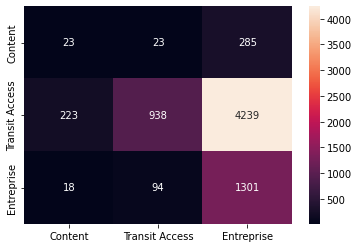

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Name of classes
classe = ["Content","Transit Access","Entreprise"]

#Confuion matrix
conf=confusion_matrix(labels[test_mask],pred[test_mask])

sns.heatmap(data=conf,fmt='.0f',xticklabels=classe,yticklabels=classe,annot=True)

# Classification report
print(classification_report(labels[test_mask],pred[test_mask]))

0.5881676227577471


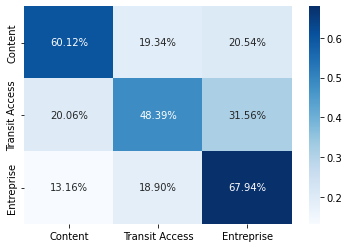

In [ ]:
# Confusion matrix
sns.heatmap(np.transpose(np.transpose(conf2)/np.sum(conf2,axis=1)), annot=True, 
            fmt='.2%', cmap='Blues',xticklabels=classe,yticklabels=classe)